# Analyse the pyradiomics features

In [1]:
# standard
import pandas as pd
import numpy as np

# fastai
from fastai.tabular import TabularDataBunch, tabular_learner, accuracy, FillMissing, Categorify, Normalize, ClassificationInterpretation, DatasetType, TabularList
from fastai.callbacks import *
from fastai.metrics import roc_curve

# personal
from src.utils import get_df_paths, calculate_age, get_df_dis, F_KEY, apply_cat, get_acc, plot_roc_curve, get_advanced_dis_df
from src.utils_radiomics import get_exp_keys, gaussianclassifier, randomforestclassifier, fully_connected_learner

# sklearn
from sklearn import tree, metrics
from sklearn.metrics import auc
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# display
import matplotlib.pyplot as plt
from IPython.display import Image
import pydot

# pyradiomics
import radiomics
radiomics.__version__

/home/biomech/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


'v3.0'

# 1. Get datasets without radiomics -> Only age, location and gender dependent

In [2]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]
ent = df['Tumor.Entitaet']

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
df_train = train
df_test = test

# display df
df_all.head()

649
140


,label1,age,loc,gen
0,0,36,Hand,M
1,0,19,Unterschenkel,M
2,0,19,Oberschenkel,F
3,0,16,Oberarm,F
4,0,18,Unterschenkel,M


In [3]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=cat_names, cont_names=[], test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names=[], procs=procs)


data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,target
Hand,M,54,0
Oberschenkel,M,13,0
Fuß,M,41,1
Unterarm,F,15,0
Oberschenkel,F,17,0
Oberschenkel,M,28,0
Fuß,M,20,0
Oberschenkel,F,12,1
os sacrum,F,54,0
Unterschenkel,F,16,0


### 1.1 Randomforest Classifier

Accuracy: 0.7285714285714285
AUC: 0.7200722394220846


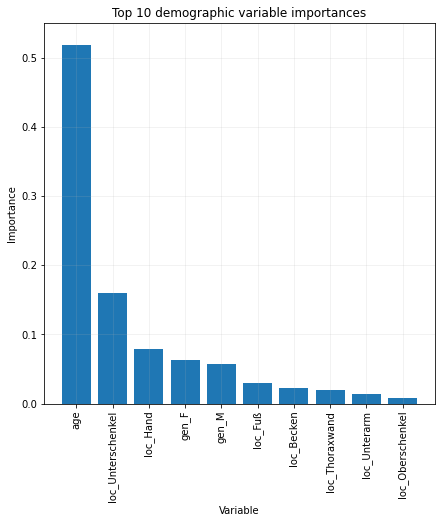

In [4]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.figure(figsize=(7,7))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} demographic variable importances');
plt.ylim([0, 0.55])
plt.grid(alpha=0.2)

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
importance_list = [f_list[sort] for sort in sort_ind[:lim]]
Image(graph.create_png())


x_demo_bar = x_values[:lim]
y_demo_bar = [imp[sort] for sort in sort_ind[:lim]]

x_demo_ticks = x_values[:lim]
y_demo_ticks = [f_list[sort] for sort in sort_ind[:lim]]

In [5]:
randomforestclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.73 +/- 0.01
Accuracy: 0.73 +/- 0.0
Sensitivity: 0.0 +/- 0.0
Specificity: 1.0 +/- 0.0


### 1.2 Gaussian Classifier

In [6]:
gaussianclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.69 +/- 0.0
Accuracy: 0.28 +/- 0.0
Sensitivity: 0.95 +/- 0.0
Specificity: 0.03 +/- 0.0


### 1.3 Neural Netowrk Classifier

In [7]:
interp_demographic = fully_connected_learner(data, rounds=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.745403,0.658699,0.728571,00:01
1,0.672169,0.606788,0.728571,00:01
2,0.625627,0.587899,0.728571,00:00
3,0.581930,0.564898,0.735714,00:00
4,0.536782,0.610681,0.685714,00:00
5,0.490422,0.720661,0.642857,00:00
6,0.444580,0.701986,0.628571,00:01
7,0.400564,0.708826,0.642857,00:01
8,0.365416,0.686711,0.657143,00:00
9,0.339311,0.686041,0.657143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.712227,0.812788,0.271429,00:01
1,0.653048,0.788041,0.271429,00:00
2,0.608388,0.767804,0.321429,00:00
3,0.570565,0.663851,0.607143,00:00
4,0.525388,0.594827,0.650000,00:00
5,0.480387,0.631155,0.692857,00:00
6,0.428080,0.642436,0.685714,00:00
7,0.384823,0.652907,0.692857,00:00
8,0.350247,0.671528,0.692857,00:00
9,0.326907,0.670693,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.734537,0.643348,0.728571,00:01
1,0.688300,0.710818,0.292857,00:01
2,0.644396,0.719734,0.335714,00:01
3,0.607497,0.636905,0.642857,00:01
4,0.566437,0.607127,0.685714,00:01
5,0.520731,0.605016,0.685714,00:00
6,0.470139,0.656161,0.685714,00:01
7,0.419653,0.651930,0.700000,00:01
8,0.379496,0.662085,0.685714,00:00
9,0.351552,0.671676,0.671429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.733411,0.624759,0.728571,00:00
1,0.673612,0.609823,0.728571,00:01
2,0.618063,0.587062,0.728571,00:01
3,0.575713,0.566549,0.728571,00:00
4,0.528686,0.560178,0.700000,00:00
5,0.483193,0.615706,0.678571,00:00
6,0.437477,0.645346,0.692857,00:01
7,0.391590,0.636947,0.685714,00:01
8,0.360051,0.662898,0.692857,00:00
9,0.334031,0.643815,0.692857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.758109,0.626815,0.728571,00:01
1,0.685876,0.664807,0.728571,00:00
2,0.630819,0.631934,0.735714,00:00
3,0.594004,0.596363,0.721429,00:00
4,0.550767,0.593807,0.685714,00:00
5,0.507071,0.597501,0.685714,00:00
6,0.458555,0.607243,0.700000,00:01
7,0.414127,0.626730,0.700000,00:00
8,0.382322,0.635369,0.692857,00:01
9,0.357809,0.634172,0.692857,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.725187,0.660845,0.728571,00:00
1,0.657876,0.637100,0.728571,00:00
2,0.601954,0.600381,0.728571,00:01
3,0.556335,0.580970,0.692857,00:01
4,0.510090,0.571162,0.692857,00:00
5,0.466118,0.620691,0.700000,00:00
6,0.420056,0.611989,0.685714,00:00
7,0.376496,0.647155,0.692857,00:00
8,0.340154,0.639614,0.692857,00:00
9,0.315413,0.652532,0.700000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.694178,0.667599,0.728571,00:01
1,0.636183,0.644574,0.728571,00:00
2,0.591902,0.607292,0.728571,00:01
3,0.554321,0.605723,0.692857,00:01
4,0.512455,0.600339,0.692857,00:00
5,0.469411,0.626270,0.678571,00:01
6,0.426329,0.693738,0.650000,00:01
7,0.390268,0.674048,0.664286,00:00
8,0.352607,0.659487,0.685714,00:00
9,0.325817,0.652995,0.685714,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.796218,0.716187,0.271429,00:00
1,0.713603,0.671866,0.742857,00:00
2,0.653820,0.677521,0.564286,00:00
3,0.597253,0.581583,0.764286,00:00
4,0.546192,0.591379,0.714286,00:00
5,0.492242,0.579179,0.750000,00:00
6,0.434785,0.643117,0.714286,00:00
7,0.387006,0.630791,0.742857,00:01
8,0.350296,0.639232,0.714286,00:00
9,0.326032,0.650121,0.707143,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.738075,0.690361,0.728571,00:00
1,0.680620,0.688620,0.621429,00:00
2,0.633635,0.658556,0.685714,00:00
3,0.594203,0.628224,0.657143,00:01
4,0.545374,0.649418,0.642857,00:00
5,0.497203,0.647432,0.678571,00:00
6,0.455413,0.680713,0.671429,00:00
7,0.408889,0.699951,0.671429,00:01
8,0.370494,0.705716,0.678571,00:01
9,0.342278,0.707082,0.671429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.720670,0.647712,0.728571,00:00
1,0.664991,0.602225,0.728571,00:00
2,0.623441,0.581256,0.728571,00:00
3,0.587967,0.572418,0.692857,00:00
4,0.547750,0.581319,0.735714,00:00
5,0.502826,0.623081,0.678571,00:00
6,0.459891,0.643904,0.728571,00:00
7,0.418699,0.622224,0.685714,00:00
8,0.384188,0.610087,0.721429,00:00
9,0.361034,0.629090,0.700000,00:00


AUC: 0.59 +/- 0.04
Accuracy: 0.65 +/- 0.03
Sensitivity: 0.33 +/- 0.06
Specificity: 0.77 +/- 0.04


# 2. Now only Radiomic features

In [8]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)


ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)

# display df
df_all.head()

df_test = test

649
140


In [9]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]
cont_names = cont_names[:161]
train, valid, test = apply_cat(train, valid, test, dis, 'ent', ent)

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=[], cont_names=cont_names, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names=[], cont_names=cont_names, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)
df_all.head()

/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-LLH_firstorder_10Percentile,wavelet-LLH_firstorder_90Percentile,wavelet-LLH_firstorder_Energy,wavelet-LLH_firstorder_Entropy,wavelet-LLH_firstorder_InterquartileRange,wavelet-LLH_firstorder_Kurtosis,wavelet-LLH_firstorder_Maximum,wavelet-LLH_firstorder_MeanAbsoluteDeviation,wavelet-LLH_firstorder_Mean,wavelet-LLH_firstorder_Median,wavelet-LLH_firstorder_Minimum,wavelet-LLH_firstorder_Range,wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LLH_firstorder_RootMeanSquared,wavelet-LLH_firstorder_Skewness,wavelet-LLH_firstorder_TotalEnergy,wavelet-LLH_firstorder_Uniformity,wavelet-LLH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_MeanAbsoluteDeviation,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_Median,wavelet-LHL_firstorder_Minimum,wavelet-LHL_firstorder_Range,wavelet-LHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHL_firstorder_RootMeanSquared,wavelet-LHL_firstorder_Skewness,wavelet-LHL_firstorder_TotalEnergy,wavelet-LHL_firstorder_Uniformity,wavelet-LHL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstorder_Median,wa

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
0,15.500020,58.765416,1.308054e+10,4.032506,21.951561,8.831832,174.001975,17.160024,38.396903,34.507913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.467195,66.612836,4.626589e+08,2.697371,10.327073,5.225828,77.232934,6.350329,56.910082,57.581181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-24.941871,42.195378,1.114753e+10,4.553707,35.356870,7.945965,116.520749,25.008526,4.948465,6.494844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.175243,58.478122,3.331790e+09,3.858980,17.818996,5.631246,88.865517,15.561807,22.142780,18.896396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.115728,66.987773,6.860790e+09,4.145085,28.682225,18.094700,261.096939,20.500603,33.386308,27.626637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.1 Randomforest Classifier

Accuracy: 0.7357142857142858
AUC: 0.7275541795665634


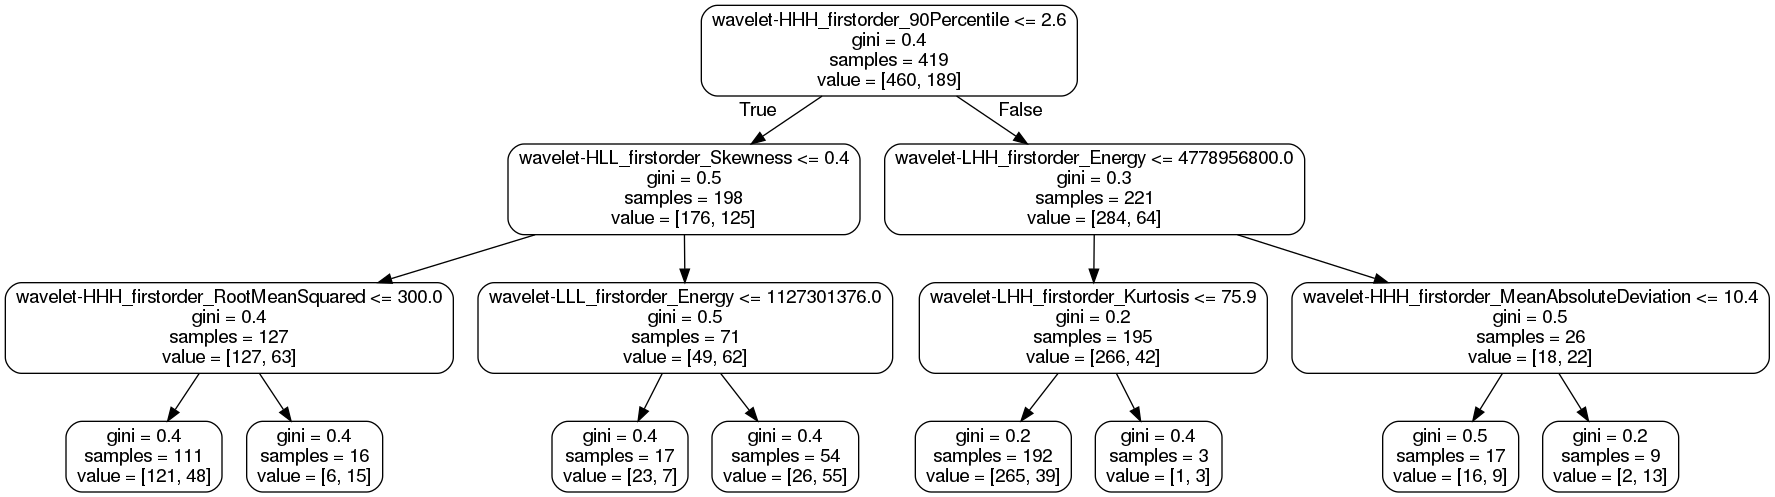

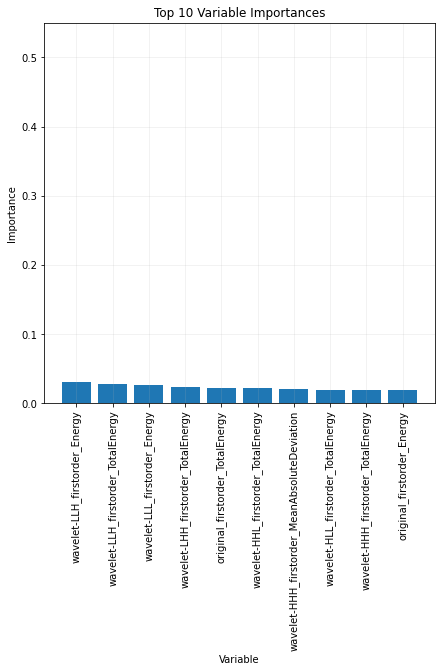

In [10]:
features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.figure(figsize=(7,7))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');
plt.ylim([0, 0.55])
plt.grid(alpha=0.2)

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
importance_list = [f_list[sort] for sort in sort_ind[:lim]]
Image(graph.create_png())

In [11]:
randomforestclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.73 +/- 0.01
Accuracy: 0.75 +/- 0.01
Sensitivity: 0.24 +/- 0.03
Specificity: 0.93 +/- 0.01


### 2.2 Gaussian Classifier

In [12]:
gaussianclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.68 +/- 0.0
Accuracy: 0.76 +/- 0.0
Sensitivity: 0.42 +/- 0.0
Specificity: 0.88 +/- 0.0


### 2.3 Neural Network Classifier

In [13]:
interp_radiomics = fully_connected_learner(data, rounds=20)

epoch,train_loss,valid_loss,accuracy,time
0,0.743915,0.687146,0.607143,00:01
1,0.675811,0.709497,0.585714,00:00
2,0.620894,0.709106,0.614286,00:00
3,0.574444,0.633453,0.657143,00:01
4,0.530911,0.696920,0.650000,00:00
5,0.490221,0.684425,0.664286,00:00
6,0.438908,0.746308,0.642857,00:00
7,0.394101,0.713149,0.664286,00:00
8,0.354197,0.756560,0.664286,00:00
9,0.322984,0.750259,0.678571,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.732665,0.665909,0.621429,00:00
1,0.669652,0.661299,0.592857,00:01
2,0.621879,0.654775,0.650000,00:00
3,0.572206,0.593769,0.757143,00:01
4,0.534198,0.571249,0.700000,00:00
5,0.487301,0.580226,0.764286,00:00
6,0.445586,0.613163,0.678571,00:00
7,0.401785,0.616587,0.735714,00:01
8,0.363905,0.593074,0.721429,00:00
9,0.339782,0.612588,0.714286,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.703833,0.651648,0.664286,00:00
1,0.650696,0.669700,0.628571,00:01
2,0.610112,0.712135,0.685714,00:00
3,0.569420,0.615304,0.700000,00:01
4,0.530237,0.655708,0.742857,00:01
5,0.494512,0.628995,0.721429,00:01
6,0.447642,0.698978,0.728571,00:01
7,0.403067,0.647548,0.771429,00:01
8,0.356547,0.636021,0.750000,00:00
9,0.328100,0.621925,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.738599,0.724145,0.407143,00:01
1,0.671669,0.648794,0.585714,00:01
2,0.612635,0.640771,0.692857,00:01
3,0.575642,0.594636,0.678571,00:00
4,0.532005,0.608315,0.700000,00:00
5,0.486537,0.598765,0.728571,00:01
6,0.441555,0.614552,0.707143,00:00
7,0.402971,0.660709,0.657143,00:00
8,0.366367,0.640925,0.671429,00:00
9,0.333182,0.623926,0.700000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.746970,0.757780,0.350000,00:00
1,0.691410,0.704528,0.571429,00:00
2,0.642189,0.651582,0.664286,00:00
3,0.601343,0.651965,0.678571,00:01
4,0.549219,0.608897,0.678571,00:00
5,0.499067,0.615178,0.721429,00:00
6,0.439957,0.603808,0.742857,00:00
7,0.389133,0.646348,0.678571,00:00
8,0.353199,0.680498,0.714286,00:01
9,0.317509,0.648007,0.721429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.703898,0.678672,0.535714,00:00
1,0.649517,0.602782,0.628571,00:01
2,0.615294,0.694863,0.585714,00:00
3,0.575524,0.616662,0.685714,00:01
4,0.534403,0.610683,0.707143,00:00
5,0.484301,0.599228,0.692857,00:00
6,0.435527,0.590876,0.785714,00:00
7,0.385113,0.582079,0.764286,00:00
8,0.343234,0.591349,0.742857,00:00
9,0.312567,0.613636,0.735714,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.711701,0.656559,0.628571,00:00
1,0.663041,0.667902,0.650000,00:00
2,0.615688,0.738244,0.714286,00:00
3,0.567366,0.679978,0.657143,00:00
4,0.527311,0.689034,0.685714,00:00
5,0.483108,0.670108,0.700000,00:00
6,0.431278,0.663164,0.728571,00:00
7,0.390554,0.700157,0.671429,00:01
8,0.346580,0.704696,0.685714,00:00
9,0.316892,0.729597,0.678571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.737292,0.787621,0.342857,00:01
1,0.673826,0.754829,0.535714,00:01
2,0.628532,0.693525,0.621429,00:01
3,0.582084,0.599559,0.750000,00:00
4,0.530457,0.670921,0.692857,00:01
5,0.485954,0.707567,0.707143,00:01
6,0.431117,0.706577,0.735714,00:01
7,0.388221,0.672298,0.692857,00:01
8,0.344176,0.705578,0.714286,00:01
9,0.317966,0.716135,0.721429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.713202,0.688819,0.564286,00:00
1,0.656773,0.672992,0.614286,00:00
2,0.608423,0.600384,0.735714,00:00
3,0.555315,0.647287,0.721429,00:00
4,0.511710,0.632248,0.685714,00:00
5,0.468367,0.574510,0.714286,00:01
6,0.427613,0.627220,0.735714,00:01
7,0.375109,0.620944,0.714286,00:00
8,0.335586,0.631722,0.728571,00:01
9,0.305194,0.629122,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.728278,0.687840,0.550000,00:00
1,0.672760,0.673032,0.628571,00:01
2,0.629621,0.687549,0.714286,00:01
3,0.587431,0.698182,0.657143,00:01
4,0.546099,0.735573,0.678571,00:01
5,0.500297,0.614338,0.728571,00:01
6,0.453601,0.638977,0.678571,00:00
7,0.406086,0.649508,0.721429,00:00
8,0.363888,0.613599,0.714286,00:00
9,0.335895,0.623259,0.721429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.717249,0.644017,0.635714,00:01
1,0.665834,0.656443,0.621429,00:00
2,0.615822,0.626436,0.692857,00:01
3,0.563558,0.799212,0.628571,00:01
4,0.517598,0.698229,0.692857,00:01
5,0.469728,0.640173,0.685714,00:00
6,0.423187,0.620585,0.707143,00:00
7,0.378242,0.667396,0.728571,00:01
8,0.340812,0.640729,0.721429,00:00
9,0.318607,0.647948,0.714286,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.725534,0.660587,0.635714,00:00
1,0.675917,0.659722,0.671429,00:01
2,0.633821,0.640464,0.664286,00:00
3,0.592684,0.657096,0.657143,00:00
4,0.543481,0.722434,0.728571,00:01
5,0.494113,0.683078,0.707143,00:01
6,0.452237,0.619403,0.735714,00:01
7,0.400353,0.611713,0.742857,00:01
8,0.360333,0.632300,0.728571,00:01
9,0.332009,0.663782,0.735714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.710781,0.637033,0.657143,00:00
1,0.654478,0.720592,0.650000,00:00
2,0.603120,0.710814,0.678571,00:01
3,0.566814,0.663413,0.664286,00:01
4,0.532771,0.743634,0.642857,00:01
5,0.491466,0.628945,0.714286,00:01
6,0.440854,0.634787,0.735714,00:01
7,0.396381,0.674158,0.707143,00:01
8,0.361342,0.696832,0.692857,00:01
9,0.331090,0.673957,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711697,0.711995,0.492857,00:00
1,0.677349,0.745669,0.614286,00:01
2,0.634994,0.788688,0.607143,00:00
3,0.591407,0.751477,0.635714,00:01
4,0.543819,0.780162,0.692857,00:00
5,0.491041,0.841722,0.614286,00:00
6,0.441997,0.788992,0.650000,00:00
7,0.397305,0.754569,0.685714,00:00
8,0.356743,0.773997,0.685714,00:00
9,0.324463,0.757436,0.657143,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.793127,0.818291,0.335714,00:00
1,0.709507,0.705416,0.542857,00:00
2,0.645689,0.707618,0.592857,00:00
3,0.594043,0.619564,0.700000,00:00
4,0.551732,0.645375,0.671429,00:01
5,0.504228,0.639942,0.678571,00:00
6,0.450496,0.638362,0.721429,00:00
7,0.398926,0.678068,0.700000,00:00
8,0.354966,0.684900,0.692857,00:00
9,0.325587,0.659142,0.707143,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.718082,0.709325,0.485714,00:00
1,0.668798,0.713912,0.578571,00:00
2,0.627402,0.673541,0.607143,00:01
3,0.586517,0.626412,0.671429,00:00
4,0.543569,0.782200,0.642857,00:00
5,0.495093,0.582271,0.707143,00:01
6,0.446128,0.615344,0.700000,00:00
7,0.394334,0.610100,0.700000,00:00
8,0.360734,0.648796,0.707143,00:01
9,0.325947,0.633171,0.692857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.732331,0.727957,0.485714,00:00
1,0.663263,0.726649,0.550000,00:00
2,0.621205,0.709221,0.607143,00:00
3,0.568845,0.708570,0.635714,00:01
4,0.523263,0.678580,0.721429,00:00
5,0.486989,0.793584,0.628571,00:01
6,0.438504,0.665287,0.735714,00:00
7,0.397489,0.690291,0.700000,00:01
8,0.355502,0.700678,0.714286,00:00
9,0.324089,0.699259,0.707143,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.685176,0.665568,0.592857,00:00
1,0.641558,0.652555,0.671429,00:01
2,0.586851,0.684588,0.721429,00:00
3,0.542991,0.725963,0.664286,00:00
4,0.505730,0.723099,0.742857,00:00
5,0.460503,0.633907,0.757143,00:00
6,0.416211,0.620951,0.735714,00:00
7,0.377522,0.671952,0.750000,00:00
8,0.342620,0.692691,0.764286,00:00
9,0.313246,0.690083,0.778571,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.708123,0.616308,0.742857,00:01
1,0.659984,0.639743,0.692857,00:00
2,0.600247,0.656644,0.664286,00:00
3,0.564797,0.638510,0.685714,00:00
4,0.525460,0.619748,0.685714,00:00
5,0.485685,0.627360,0.728571,00:00
6,0.438662,0.630534,0.757143,00:00
7,0.388850,0.658816,0.714286,00:00
8,0.354479,0.622832,0.742857,00:00
9,0.324483,0.626371,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.708619,0.688139,0.528571,00:00
1,0.659878,0.691808,0.650000,00:00
2,0.613473,0.726068,0.664286,00:00
3,0.569448,0.697807,0.692857,00:00
4,0.529165,0.656886,0.700000,00:00
5,0.482694,0.684628,0.700000,00:00
6,0.433149,0.653799,0.735714,00:00
7,0.385969,0.678843,0.757143,00:00
8,0.346967,0.676291,0.764286,00:00
9,0.320787,0.684447,0.750000,00:00


AUC: 0.72 +/- 0.02
Accuracy: 0.72 +/- 0.03
Sensitivity: 0.51 +/- 0.05
Specificity: 0.8 +/- 0.03


# 3. Get datasets with all features

In [75]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label1', 'label2']
DEP_KEY = 'label1'

REM_KEYS.remove(DEP_KEY)
print(REM_KEYS)

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)


ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
train = train.drop(columns=REM_KEYS)

# display df
df_all.head()

df_test = test.drop(columns=REM_KEYS)

# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]
cont_names = cont_names[:161]


# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names= cat_names, cont_names = cont_names, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names = cont_names, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

df_all[DEP_KEY]

['Unnamed: 0', 'label2']
649
140


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-LLH_firstorder_10Percentile,wavelet-LLH_firstorder_90Percentile,wavelet-LLH_firstorder_Energy,wavelet-LLH_firstorder_Entropy,wavelet-LLH_firstorder_InterquartileRange,wavelet-LLH_firstorder_Kurtosis,wavelet-LLH_firstorder_Maximum,wavelet-LLH_firstorder_MeanAbsoluteDeviation,wavelet-LLH_firstorder_Mean,wavelet-LLH_firstorder_Median,wavelet-LLH_firstorder_Minimum,wavelet-LLH_firstorder_Range,wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LLH_firstorder_RootMeanSquared,wavelet-LLH_firstorder_Skewness,wavelet-LLH_firstorder_TotalEnergy,wavelet-LLH_firstorder_Uniformity,wavelet-LLH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_MeanAbsoluteDeviation,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_Median,wavelet-LHL_firstorder_Minimum,wavelet-LHL_firstorder_Range,wavelet-LHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHL_firstorder_RootMeanSquared,wavelet-LHL_firstorder_Skewness,wavelet-LHL_firstorder_TotalEnergy,wavelet-LHL_firstorder_Uniformity,wavelet-LHL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstord

0      0
1      0
2      0
3      0
4      0
      ..
135    0
136    0
137    0
138    0
139    0
Name: label1, Length: 789, dtype: int64

### 3.1 Random Forest Classifier

Accuracy: 0.7857142857142857
AUC: 0.7701238390092879


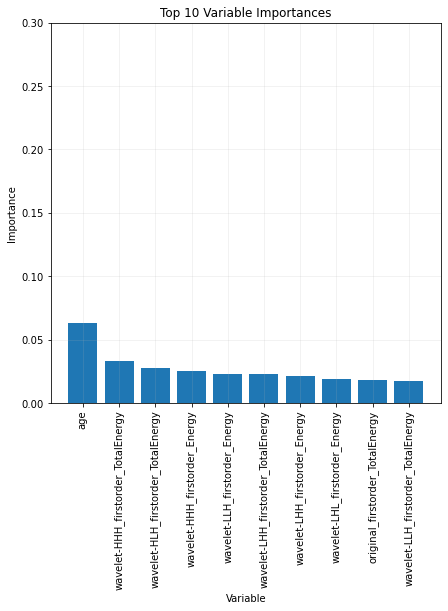

In [76]:
features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.figure(figsize=(7,7))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');
plt.ylim([0, 0.3])
plt.grid(alpha=0.2)

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
importance_list = [f_list[sort] for sort in sort_ind[:lim]]
Image(graph.create_png())

x_all_bar = x_values[:lim]
y_all_bar = [imp[sort] for sort in sort_ind[:lim]]

x_all_ticks = x_values[:lim]
y_all_ticks = [f_list[sort] for sort in sort_ind[:lim]]

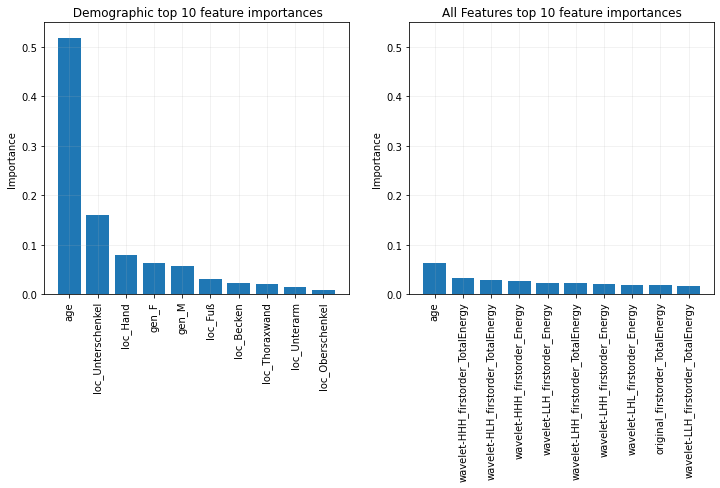

In [77]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.bar(x_demo_bar, y_demo_bar, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_demo_ticks, y_demo_ticks, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.title(f' Demographic top {lim} feature importances');
plt.ylim([0, 0.55])
plt.grid(alpha=0.2)

plt.subplot(1, 2, 2)
plt.bar(x_all_bar, y_all_bar, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_all_ticks, y_all_ticks, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.title(f'All Features top {lim} feature importances');
plt.ylim([0, 0.55])
plt.grid(alpha=0.2)

In [63]:
randomforestclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.76 +/- 0.01
Accuracy: 0.77 +/- 0.01
Sensitivity: 0.26 +/- 0.03
Specificity: 0.96 +/- 0.01


### 3.2 Gaussian Classifier

In [64]:
gaussianclassifier(df_all, DEP_KEY, trainlen)

AUC: 0.68 +/- 0.0
Accuracy: 0.76 +/- 0.0
Sensitivity: 0.42 +/- 0.0
Specificity: 0.88 +/- 0.0


### 3.3 Neural Network Classifier

In [39]:
interp_all = fully_connected_learner(data, rounds=20)

epoch,train_loss,valid_loss,accuracy,time
0,0.747757,0.726899,0.428571,00:01
1,0.700489,0.717322,0.592857,00:01
2,0.642999,0.737992,0.585714,00:01
3,0.592395,0.608264,0.707143,00:01
4,0.542895,0.742833,0.628571,00:01
5,0.487943,0.736811,0.700000,00:01
6,0.435752,0.666692,0.692857,00:01
7,0.387422,0.655847,0.692857,00:01
8,0.345328,0.687018,0.678571,00:01
9,0.311166,0.697138,0.671429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.737583,0.679057,0.600000,00:01
1,0.677642,0.728060,0.635714,00:00
2,0.628436,0.744880,0.657143,00:01
3,0.579764,0.699519,0.692857,00:01
4,0.535792,0.683762,0.692857,00:00
5,0.478930,0.744069,0.650000,00:00
6,0.421848,0.737357,0.707143,00:01
7,0.366898,0.707828,0.707143,00:00
8,0.327025,0.742222,0.700000,00:01
9,0.291542,0.747886,0.700000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.707127,0.716657,0.492857,00:00
1,0.651388,0.653648,0.628571,00:00
2,0.607003,0.596492,0.735714,00:00
3,0.561082,0.596725,0.728571,00:00
4,0.507521,0.666542,0.714286,00:01
5,0.460385,0.672314,0.707143,00:01
6,0.411993,0.585916,0.757143,00:01
7,0.368218,0.627944,0.721429,00:01
8,0.321442,0.633022,0.742857,00:01
9,0.288767,0.625788,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.704620,0.647420,0.650000,00:00
1,0.651869,0.710323,0.628571,00:00
2,0.608827,0.819165,0.635714,00:00
3,0.572039,0.710666,0.650000,00:01
4,0.526618,0.767807,0.650000,00:01
5,0.481089,0.710265,0.728571,00:01
6,0.434026,0.779552,0.685714,00:00
7,0.385866,0.792282,0.685714,00:00
8,0.341518,0.783089,0.700000,00:01
9,0.305476,0.812230,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.770344,0.714163,0.514286,00:01
1,0.682791,0.731850,0.585714,00:00
2,0.621993,0.690019,0.607143,00:01
3,0.575621,0.672453,0.728571,00:01
4,0.528370,0.684082,0.700000,00:01
5,0.475707,0.650902,0.714286,00:01
6,0.429066,0.646591,0.721429,00:01
7,0.377624,0.620576,0.742857,00:01
8,0.335785,0.638178,0.721429,00:00
9,0.304175,0.611145,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.754808,0.650292,0.692857,00:00
1,0.691723,0.657892,0.642857,00:01
2,0.633036,0.751075,0.642857,00:00
3,0.579974,0.730050,0.650000,00:01
4,0.536055,0.678006,0.700000,00:01
5,0.488870,0.708311,0.728571,00:01
6,0.434442,0.611517,0.757143,00:01
7,0.379473,0.659139,0.728571,00:01
8,0.332893,0.650878,0.750000,00:01
9,0.300410,0.670676,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.765761,0.703040,0.500000,00:01
1,0.696823,0.754739,0.592857,00:01
2,0.649939,0.731223,0.614286,00:01
3,0.595758,0.816485,0.642857,00:01
4,0.545612,0.763194,0.635714,00:01
5,0.491381,0.761365,0.664286,00:01
6,0.431551,0.727820,0.700000,00:01
7,0.386431,0.740493,0.685714,00:01
8,0.342166,0.717978,0.707143,00:00
9,0.306586,0.734980,0.685714,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.756117,0.768227,0.335714,00:01
1,0.700447,0.734009,0.521429,00:01
2,0.651921,0.756466,0.550000,00:01
3,0.608482,0.658097,0.614286,00:01
4,0.562855,0.729842,0.614286,00:00
5,0.514976,0.651505,0.735714,00:01
6,0.456855,0.575895,0.757143,00:01
7,0.412938,0.668814,0.728571,00:01
8,0.364331,0.656031,0.742857,00:01
9,0.329758,0.661257,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.693220,0.661185,0.678571,00:01
1,0.655987,0.672188,0.607143,00:01
2,0.607534,0.741266,0.628571,00:01
3,0.567594,0.725714,0.678571,00:00
4,0.524751,0.673586,0.714286,00:01
5,0.477327,0.700635,0.700000,00:01
6,0.429837,0.644616,0.728571,00:01
7,0.382891,0.620035,0.735714,00:01
8,0.342115,0.667391,0.735714,00:01
9,0.306769,0.684685,0.728571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.740533,0.674733,0.550000,00:01
1,0.676934,0.668504,0.578571,00:00
2,0.626750,0.722282,0.692857,00:01
3,0.571846,0.635083,0.742857,00:00
4,0.524520,0.692645,0.678571,00:01
5,0.469821,0.721127,0.742857,00:01
6,0.419110,0.671591,0.728571,00:01
7,0.377051,0.643782,0.771429,00:01
8,0.337645,0.682190,0.771429,00:01
9,0.303874,0.664815,0.778571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.708232,0.686215,0.492857,00:01
1,0.655981,0.692557,0.642857,00:00
2,0.611793,0.691925,0.664286,00:00
3,0.566474,0.667314,0.685714,00:01
4,0.514673,0.602620,0.700000,00:01
5,0.473809,0.657232,0.685714,00:01
6,0.430148,0.572115,0.757143,00:01
7,0.378647,0.630696,0.728571,00:01
8,0.339255,0.641252,0.707143,00:01
9,0.308983,0.636082,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.722859,0.662839,0.621429,00:00
1,0.669532,0.660758,0.657143,00:01
2,0.620957,0.765604,0.628571,00:00
3,0.580908,0.705834,0.707143,00:01
4,0.526203,0.676851,0.692857,00:01
5,0.477760,0.644492,0.721429,00:00
6,0.429397,0.720448,0.728571,00:01
7,0.380549,0.621310,0.714286,00:01
8,0.336028,0.612490,0.728571,00:00
9,0.301554,0.607652,0.742857,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.749494,0.735330,0.392857,00:01
1,0.687253,0.690761,0.621429,00:00
2,0.634508,0.590259,0.721429,00:01
3,0.590824,0.686588,0.657143,00:01
4,0.538768,0.625783,0.700000,00:00
5,0.489365,0.631335,0.692857,00:01
6,0.431684,0.649518,0.728571,00:01
7,0.377183,0.608156,0.700000,00:00
8,0.329960,0.630317,0.728571,00:01
9,0.295912,0.608612,0.728571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.730939,0.795571,0.357143,00:01
1,0.659634,0.668427,0.600000,00:01
2,0.606154,0.602462,0.650000,00:00
3,0.557919,0.667535,0.628571,00:01
4,0.504948,0.703720,0.664286,00:00
5,0.458289,0.594876,0.764286,00:01
6,0.411518,0.667277,0.707143,00:01
7,0.361501,0.629419,0.700000,00:01
8,0.322384,0.658381,0.714286,00:01
9,0.289832,0.655132,0.714286,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.754742,0.679457,0.550000,00:00
1,0.689782,0.686875,0.592857,00:01
2,0.639941,0.708135,0.635714,00:00
3,0.589778,0.645221,0.728571,00:01
4,0.532910,0.677119,0.692857,00:01
5,0.473953,0.638986,0.735714,00:01
6,0.425372,0.618061,0.728571,00:01
7,0.374938,0.648382,0.735714,00:01
8,0.342206,0.633734,0.750000,00:00
9,0.309234,0.639879,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.720321,0.744107,0.350000,00:01
1,0.663233,0.744337,0.564286,00:01
2,0.609570,0.727505,0.628571,00:00
3,0.566913,0.756698,0.600000,00:00
4,0.530036,0.650501,0.678571,00:01
5,0.478306,0.677976,0.664286,00:00
6,0.426894,0.663857,0.700000,00:01
7,0.375284,0.683152,0.642857,00:01
8,0.333585,0.717408,0.671429,00:00
9,0.304340,0.748507,0.678571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.722345,0.713408,0.464286,00:00
1,0.665829,0.688781,0.564286,00:00
2,0.621285,0.662520,0.671429,00:00
3,0.580761,0.696450,0.678571,00:01
4,0.532238,0.623466,0.700000,00:01
5,0.479717,0.661489,0.707143,00:01
6,0.422696,0.663797,0.728571,00:01
7,0.380981,0.652844,0.714286,00:01
8,0.340329,0.678565,0.721429,00:00
9,0.309114,0.685108,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.746139,0.717497,0.471429,00:00
1,0.678634,0.701418,0.621429,00:01
2,0.619986,0.688742,0.607143,00:01
3,0.571611,0.748350,0.635714,00:00
4,0.525486,0.669790,0.721429,00:01
5,0.478455,0.622959,0.692857,00:01
6,0.433606,0.647211,0.692857,00:01
7,0.383746,0.692198,0.678571,00:01
8,0.343619,0.685151,0.664286,00:00
9,0.303704,0.661511,0.671429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.656262,0.604552,0.742857,00:01
1,0.616960,0.668286,0.650000,00:01
2,0.583832,0.573294,0.735714,00:01
3,0.541225,0.555182,0.792857,00:01
4,0.491796,0.586329,0.728571,00:01
5,0.443734,0.598148,0.721429,00:01
6,0.396159,0.650409,0.721429,00:01
7,0.358638,0.626163,0.721429,00:01
8,0.315311,0.610537,0.757143,00:01
9,0.281724,0.609261,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.732118,0.706904,0.457143,00:01
1,0.685875,0.701638,0.614286,00:00
2,0.641228,0.635565,0.664286,00:00
3,0.601840,0.595190,0.678571,00:01
4,0.557417,0.656330,0.735714,00:01
5,0.502615,0.629894,0.678571,00:01
6,0.444017,0.667714,0.728571,00:01
7,0.386396,0.675396,0.707143,00:01
8,0.339414,0.646660,0.742857,00:00
9,0.309439,0.669117,0.692857,00:01


AUC: 0.73 +/- 0.03
Accuracy: 0.73 +/- 0.02
Sensitivity: 0.52 +/- 0.06
Specificity: 0.81 +/- 0.03


### Analyse the top 10 most important single features as an independent classifier

In [65]:
for i in range(10):
    select = importance_list[i]
    print(f'Feature: {select}')

    # create databunch
    data = TabularDataBunch.from_df(
        path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
        cat_names=[], cont_names=[select], test_df=test, procs=procs)

    data_test = TabularDataBunch.from_df(
        path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
        cat_names=[], cont_names=[select], procs=procs)


    data.test_ds.x = data_test.train_ds.x
    data.test_ds.y = data_test.train_ds.y

    # Show databunch
    data.train_dl.num_workers = 12
    data.train_dl.batch_size = 32

    fully_connected_learner(data, rounds=5)

Feature: age


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.701301,0.633536,0.728571,00:01
1,0.674526,0.629487,0.657143,00:01
2,0.659173,0.626389,0.635714,00:01
3,0.647737,0.637164,0.628571,00:01
4,0.632702,0.612086,0.614286,00:01
5,0.614141,0.605174,0.628571,00:01
6,0.599913,0.581141,0.671429,00:01
7,0.590228,0.586454,0.664286,00:01
8,0.583119,0.590528,0.678571,00:01
9,0.576595,0.587672,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711151,0.688867,0.542857,00:01
1,0.695479,0.687173,0.535714,00:01
2,0.681657,0.666638,0.578571,00:01
3,0.663201,0.656506,0.528571,00:01
4,0.648353,0.601333,0.621429,00:01
5,0.629106,0.592209,0.728571,00:01
6,0.612961,0.604619,0.650000,00:01
7,0.599070,0.594968,0.671429,00:01
8,0.590080,0.589138,0.664286,00:01
9,0.582834,0.588314,0.664286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.683435,0.648881,0.700000,00:00
1,0.670821,0.651488,0.585714,00:01
2,0.659768,0.608572,0.664286,00:01
3,0.641254,0.634926,0.571429,00:01
4,0.624377,0.619857,0.607143,00:01
5,0.613606,0.619130,0.628571,00:01
6,0.602577,0.611150,0.650000,00:01
7,0.590332,0.582057,0.692857,00:01
8,0.583037,0.578994,0.707143,00:01
9,0.578403,0.586632,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.679082,0.715128,0.392857,00:01
1,0.675045,0.707479,0.514286,00:01
2,0.660662,0.650645,0.550000,00:01
3,0.642972,0.624781,0.692857,00:01
4,0.626007,0.623473,0.635714,00:01
5,0.608127,0.593614,0.671429,00:01
6,0.596733,0.579013,0.671429,00:01
7,0.585921,0.582075,0.635714,00:01
8,0.579839,0.579970,0.678571,00:01
9,0.574335,0.580991,0.678571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.755442,0.696183,0.614286,00:01
1,0.732488,0.687696,0.607143,00:01
2,0.711015,0.667392,0.542857,00:00
3,0.688835,0.633962,0.564286,00:00
4,0.668536,0.651923,0.607143,00:01
5,0.648947,0.618622,0.671429,00:01
6,0.625799,0.620807,0.621429,00:01
7,0.612892,0.608792,0.657143,00:01
8,0.600153,0.604797,0.657143,00:01
9,0.592817,0.593892,0.657143,00:01


AUC: 0.71 +/- 0.01
Accuracy: 0.71 +/- 0.01
Sensitivity: 0.24 +/- 0.05
Specificity: 0.89 +/- 0.03


Feature: wavelet-HHH_firstorder_TotalEnergy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.687321,0.692927,0.585714,00:01
1,0.673690,0.710675,0.492857,00:01
2,0.662283,0.660612,0.714286,00:01
3,0.646606,0.591348,0.771429,00:01
4,0.630954,0.661328,0.714286,00:01
5,0.616639,0.757162,0.707143,00:01
6,0.601694,0.666846,0.735714,00:01
7,0.593855,0.748748,0.742857,00:01
8,0.586426,0.701759,0.785714,00:01
9,0.578486,0.702940,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.712765,0.607379,0.757143,00:01
1,0.693162,0.650458,0.564286,00:01
2,0.674990,0.770251,0.571429,00:01
3,0.660251,0.753951,0.792857,00:01
4,0.639885,0.695545,0.707143,00:01
5,0.625242,0.690432,0.692857,00:01
6,0.610919,0.672405,0.771429,00:01
7,0.598230,0.639163,0.764286,00:01
8,0.588189,0.662536,0.792857,00:01
9,0.581785,0.645178,0.778571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.714377,0.757694,0.271429,00:01
1,0.714562,0.774370,0.364286,00:00
2,0.698442,0.653814,0.721429,00:01
3,0.674849,0.692189,0.550000,00:01
4,0.651978,0.659630,0.642857,00:01
5,0.634907,0.606338,0.721429,00:01
6,0.622825,0.621233,0.635714,00:01
7,0.609269,0.608809,0.678571,00:00
8,0.597261,0.597166,0.735714,00:01
9,0.589381,0.599059,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.730824,0.669347,0.628571,00:01
1,0.702869,0.671172,0.564286,00:01
2,0.690019,0.783891,0.307143,00:01
3,0.666325,0.649677,0.778571,00:01
4,0.650768,0.791476,0.564286,00:01
5,0.633436,0.633171,0.757143,00:01
6,0.617673,0.618796,0.700000,00:01
7,0.605790,0.599367,0.707143,00:01
8,0.592793,0.587889,0.792857,00:01
9,0.586555,0.589696,0.785714,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.690217,0.624805,0.792857,00:01
1,0.683318,0.637281,0.764286,00:00
2,0.668358,0.695516,0.664286,00:01
3,0.653833,0.708861,0.507143,00:00
4,0.634904,0.740780,0.542857,00:01
5,0.618478,0.785812,0.771429,00:01
6,0.608788,0.725308,0.785714,00:01
7,0.599739,0.936444,0.714286,00:01
8,0.590768,0.873515,0.778571,00:00
9,0.583426,0.818569,0.778571,00:01


AUC: 0.64 +/- 0.0
Accuracy: 0.71 +/- 0.01
Sensitivity: 0.14 +/- 0.07
Specificity: 0.93 +/- 0.04


Feature: wavelet-HLH_firstorder_TotalEnergy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.687672,0.689849,0.585714,00:01
1,0.681224,0.693617,0.557143,00:01
2,0.672433,0.733031,0.550000,00:01
3,0.661608,0.764230,0.635714,00:01
4,0.635828,0.782580,0.685714,00:01
5,0.619231,0.755700,0.678571,00:01
6,0.610165,0.735913,0.685714,00:01
7,0.598511,0.631260,0.692857,00:01
8,0.590574,0.638442,0.750000,00:01
9,0.584182,0.633272,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.707097,0.678230,0.678571,00:01
1,0.680373,0.664298,0.792857,00:01
2,0.666664,0.782374,0.735714,00:01
3,0.657551,0.705968,0.585714,00:01
4,0.639426,0.609053,0.735714,00:01
5,0.623058,0.615835,0.735714,00:01
6,0.611353,0.598065,0.785714,00:01
7,0.602009,0.593558,0.785714,00:01
8,0.591639,0.601746,0.792857,00:01
9,0.582918,0.597121,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.713209,0.707496,0.450000,00:01
1,0.695923,0.722102,0.485714,00:01
2,0.686412,0.690356,0.578571,00:01
3,0.663798,0.766950,0.507143,00:01
4,0.645309,0.678205,0.628571,00:01
5,0.626152,0.711672,0.764286,00:01
6,0.613107,0.714747,0.785714,00:01
7,0.604344,0.665112,0.771429,00:01
8,0.596921,0.698298,0.764286,00:01
9,0.587265,0.701591,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.707341,0.724020,0.385714,00:01
1,0.689408,0.692457,0.592857,00:01
2,0.674528,0.641802,0.628571,00:01
3,0.659104,0.870524,0.585714,00:01
4,0.641707,0.797197,0.721429,00:01
5,0.624509,0.973977,0.735714,00:01
6,0.611996,0.837385,0.614286,00:01
7,0.600668,0.845143,0.757143,00:01
8,0.590394,0.864880,0.785714,00:01
9,0.585067,0.905886,0.785714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.777832,0.827057,0.271429,00:01
1,0.725103,0.751202,0.414286,00:01
2,0.697443,0.686864,0.628571,00:01
3,0.668830,0.735353,0.471429,00:01
4,0.653465,0.629410,0.685714,00:01
5,0.638929,0.671086,0.614286,00:01
6,0.626467,0.678377,0.571429,00:01
7,0.612948,0.638426,0.721429,00:01
8,0.600949,0.600997,0.792857,00:01
9,0.593278,0.608682,0.785714,00:01


AUC: 0.65 +/- 0.02
Accuracy: 0.73 +/- 0.01
Sensitivity: 0.13 +/- 0.02
Specificity: 0.95 +/- 0.02


Feature: wavelet-HHH_firstorder_Energy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.719455,0.610303,0.757143,00:01
1,0.697389,0.640315,0.792857,00:01
2,0.686544,0.745464,0.557143,00:01
3,0.663616,0.707342,0.557143,00:01
4,0.642950,0.643136,0.657143,00:01
5,0.628812,0.654908,0.671429,00:01
6,0.616358,0.587847,0.785714,00:01
7,0.604267,0.607286,0.721429,00:01
8,0.593086,0.601349,0.714286,00:01
9,0.585672,0.605275,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.690252,0.643542,0.764286,00:01
1,0.673056,0.696693,0.750000,00:01
2,0.666566,0.741669,0.514286,00:01
3,0.652162,0.667776,0.764286,00:01
4,0.633680,0.688360,0.707143,00:01
5,0.620956,0.794122,0.785714,00:01
6,0.608069,0.714939,0.714286,00:01
7,0.597600,0.708300,0.692857,00:01
8,0.589091,0.707568,0.714286,00:01
9,0.581686,0.716389,0.728571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.739010,0.715732,0.428571,00:01
1,0.703104,0.807591,0.364286,00:01
2,0.687691,0.676289,0.607143,00:01
3,0.665094,0.826050,0.585714,00:01
4,0.646430,0.739832,0.671429,00:01
5,0.631094,0.631116,0.750000,00:01
6,0.613700,0.603444,0.692857,00:01
7,0.605712,0.624133,0.678571,00:01
8,0.597493,0.647702,0.692857,00:01
9,0.590967,0.624369,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.750097,0.751883,0.271429,00:01
1,0.714192,0.724022,0.471429,00:01
2,0.697564,0.720413,0.550000,00:01
3,0.677892,0.670707,0.607143,00:01
4,0.654420,0.650524,0.621429,00:01
5,0.637053,0.635111,0.685714,00:01
6,0.622993,0.620959,0.721429,00:01
7,0.608371,0.647283,0.707143,00:01
8,0.598056,0.630326,0.664286,00:01
9,0.586966,0.615972,0.657143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.649091,0.602236,0.742857,00:01
1,0.650452,0.607751,0.721429,00:01
2,0.640122,0.652287,0.678571,00:01
3,0.628871,0.692033,0.792857,00:01
4,0.614881,0.694265,0.650000,00:01
5,0.604328,0.688566,0.792857,00:01
6,0.594538,0.665359,0.628571,00:01
7,0.586790,0.625635,0.707143,00:01
8,0.579556,0.638429,0.728571,00:01
9,0.576057,0.650661,0.735714,00:01


AUC: 0.6 +/- 0.01
Accuracy: 0.68 +/- 0.02
Sensitivity: 0.14 +/- 0.1
Specificity: 0.88 +/- 0.06


Feature: wavelet-LLH_firstorder_Energy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.681394,0.738736,0.450000,00:01
1,0.663698,0.681115,0.578571,00:01
2,0.658393,0.682200,0.635714,00:01
3,0.638862,0.645106,0.592857,00:01
4,0.622649,0.612321,0.721429,00:01
5,0.608102,0.620969,0.771429,00:01
6,0.598551,0.607599,0.671429,00:01
7,0.589449,0.620995,0.778571,00:01
8,0.582727,0.598479,0.742857,00:01
9,0.579282,0.607861,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.675995,0.621957,0.785714,00:01
1,0.671303,0.639464,0.671429,00:01
2,0.653965,0.627294,0.785714,00:01
3,0.638157,0.670380,0.607143,00:01
4,0.627097,0.711986,0.592857,00:01
5,0.618080,0.652526,0.628571,00:01
6,0.605404,0.579412,0.785714,00:01
7,0.595313,0.597407,0.728571,00:01
8,0.586990,0.595022,0.771429,00:01
9,0.581187,0.596019,0.771429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.761350,0.817949,0.300000,00:01
1,0.701800,0.769189,0.564286,00:01
2,0.680069,0.765793,0.564286,00:01
3,0.652531,0.610060,0.728571,00:01
4,0.634610,0.649175,0.600000,00:01
5,0.619615,0.623962,0.692857,00:01
6,0.606380,0.616514,0.700000,00:01
7,0.597338,0.628297,0.742857,00:01
8,0.587652,0.650115,0.785714,00:01
9,0.582900,0.654688,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.720327,0.808723,0.271429,00:01
1,0.703249,0.778267,0.400000,00:01
2,0.696854,0.735921,0.521429,00:01
3,0.677453,0.683965,0.514286,00:01
4,0.657197,0.675641,0.621429,00:01
5,0.642331,0.627264,0.614286,00:01
6,0.626412,0.592441,0.714286,00:01
7,0.612886,0.601968,0.728571,00:01
8,0.604530,0.616948,0.707143,00:01
9,0.596989,0.647277,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.703217,0.695389,0.592857,00:01
1,0.705069,0.788716,0.521429,00:01
2,0.696915,0.699083,0.528571,00:01
3,0.674964,0.688724,0.664286,00:01
4,0.653260,0.682024,0.614286,00:01
5,0.635381,0.678880,0.664286,00:01
6,0.623161,0.652691,0.792857,00:01
7,0.610711,0.650842,0.721429,00:01
8,0.599651,0.658380,0.642857,00:01
9,0.593640,0.663081,0.628571,00:01


AUC: 0.61 +/- 0.01
Accuracy: 0.69 +/- 0.03
Sensitivity: 0.21 +/- 0.08
Specificity: 0.87 +/- 0.07


Feature: wavelet-LHH_firstorder_TotalEnergy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.657903,0.626977,0.785714,00:01
1,0.659205,0.709396,0.607143,00:01
2,0.651825,0.767252,0.771429,00:01
3,0.633111,0.637467,0.664286,00:01
4,0.625097,0.623152,0.735714,00:01
5,0.612161,0.650434,0.750000,00:01
6,0.601593,0.677655,0.750000,00:01
7,0.591307,0.764785,0.778571,00:01
8,0.583604,0.734892,0.728571,00:01
9,0.577543,0.710532,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.698626,0.720662,0.285714,00:01
1,0.686845,0.741161,0.564286,00:01
2,0.674050,0.777353,0.578571,00:01
3,0.655920,0.711398,0.485714,00:01
4,0.636725,0.661165,0.707143,00:01
5,0.622869,0.665450,0.771429,00:01
6,0.609397,0.846633,0.721429,00:01
7,0.596262,0.737966,0.721429,00:01
8,0.588127,0.751964,0.728571,00:01
9,0.583001,0.674368,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.738213,0.738760,0.271429,00:01
1,0.701256,0.927921,0.328571,00:01
2,0.682429,0.642775,0.692857,00:01
3,0.659997,0.704340,0.564286,00:01
4,0.639772,0.616477,0.700000,00:01
5,0.620905,0.692577,0.657143,00:01
6,0.609399,0.614825,0.635714,00:01
7,0.601240,0.605394,0.792857,00:01
8,0.592668,0.588789,0.785714,00:01
9,0.585230,0.589750,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.688752,0.693143,0.535714,00:01
1,0.679118,0.708442,0.507143,00:01
2,0.670331,0.664023,0.550000,00:01
3,0.652481,0.641173,0.635714,00:01
4,0.634194,0.640622,0.635714,00:01
5,0.619084,0.641491,0.778571,00:01
6,0.606869,0.605624,0.728571,00:01
7,0.594205,0.603895,0.785714,00:01
8,0.587602,0.638229,0.771429,00:01
9,0.579983,0.609564,0.785714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.732187,0.677581,0.571429,00:01
1,0.696030,0.636964,0.614286,00:01
2,0.682192,0.699553,0.521429,00:01
3,0.657572,0.661239,0.728571,00:01
4,0.640919,0.658759,0.778571,00:01
5,0.620139,0.688021,0.771429,00:01
6,0.604030,0.697301,0.692857,00:00
7,0.592724,0.665714,0.771429,00:01
8,0.584096,0.706075,0.771429,00:01
9,0.581880,0.692581,0.771429,00:01


AUC: 0.64 +/- 0.01
Accuracy: 0.7 +/- 0.02
Sensitivity: 0.11 +/- 0.03
Specificity: 0.92 +/- 0.03


Feature: wavelet-LHH_firstorder_Energy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.681346,0.713134,0.507143,00:00
1,0.676709,0.661953,0.550000,00:01
2,0.669742,0.728915,0.692857,00:01
3,0.651923,0.679550,0.642857,00:01
4,0.634283,0.723581,0.678571,00:01
5,0.622767,0.688052,0.621429,00:01
6,0.606985,0.641190,0.664286,00:01
7,0.596857,0.658626,0.692857,00:01
8,0.588464,0.612877,0.678571,00:01
9,0.582500,0.650105,0.642857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.683323,0.702256,0.535714,00:01
1,0.675417,0.705487,0.614286,00:01
2,0.659413,0.721186,0.557143,00:01
3,0.644618,0.691253,0.550000,00:01
4,0.631063,0.688648,0.678571,00:01
5,0.615604,0.675665,0.778571,00:01
6,0.607229,0.730070,0.750000,00:01
7,0.597300,0.727693,0.735714,00:01
8,0.588918,0.717386,0.778571,00:01
9,0.582752,0.703579,0.778571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.707391,0.623860,0.750000,00:01
1,0.694330,0.636560,0.707143,00:01
2,0.679614,0.760966,0.614286,00:01
3,0.662113,0.730883,0.600000,00:01
4,0.640900,0.759661,0.642857,00:01
5,0.624059,0.689862,0.757143,00:01
6,0.613917,0.672171,0.700000,00:01
7,0.601338,0.626523,0.778571,00:01
8,0.592876,0.639949,0.692857,00:01
9,0.586439,0.640953,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.679194,0.699282,0.514286,00:01
1,0.665725,0.747297,0.485714,00:01
2,0.656924,0.645560,0.642857,00:01
3,0.645134,0.726144,0.542857,00:01
4,0.631470,0.606978,0.792857,00:01
5,0.615026,0.685836,0.628571,00:01
6,0.601739,0.621082,0.771429,00:01
7,0.594300,0.642553,0.785714,00:01
8,0.588370,0.642880,0.785714,00:01
9,0.581093,0.650055,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.790828,0.663475,0.785714,00:01
1,0.735725,0.728235,0.642857,00:01
2,0.716311,0.742514,0.592857,00:01
3,0.692528,0.691813,0.642857,00:01
4,0.665634,0.645051,0.650000,00:01
5,0.647708,0.707826,0.678571,00:01
6,0.629612,0.682412,0.642857,00:01
7,0.618994,0.677854,0.714286,00:01
8,0.608701,0.655283,0.721429,00:01
9,0.598465,0.668780,0.721429,00:01


AUC: 0.6 +/- 0.01
Accuracy: 0.69 +/- 0.03
Sensitivity: 0.15 +/- 0.08
Specificity: 0.9 +/- 0.06


Feature: wavelet-LHL_firstorder_Energy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.695956,0.627139,0.735714,00:01
1,0.697080,0.642515,0.664286,00:01
2,0.686195,0.678785,0.621429,00:01
3,0.670413,0.651093,0.714286,00:01
4,0.652294,0.661327,0.678571,00:01
5,0.638653,0.687624,0.764286,00:01
6,0.622290,0.598485,0.771429,00:01
7,0.607336,0.580501,0.778571,00:00
8,0.595960,0.589125,0.771429,00:01
9,0.588428,0.576116,0.764286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.703331,0.690687,0.642857,00:01
1,0.687357,0.713281,0.457143,00:01
2,0.676779,0.771628,0.657143,00:01
3,0.661919,0.604956,0.700000,00:01
4,0.643925,0.619735,0.771429,00:01
5,0.624582,0.836021,0.735714,00:01
6,0.610344,0.761992,0.750000,00:01
7,0.600333,0.739814,0.771429,00:01
8,0.590928,0.788939,0.757143,00:01
9,0.584749,0.716520,0.771429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.719394,0.707390,0.621429,00:01
1,0.714819,0.729069,0.521429,00:01
2,0.699048,0.695435,0.642857,00:01
3,0.679585,0.726267,0.635714,00:01
4,0.660021,0.695461,0.542857,00:01
5,0.639589,0.618601,0.707143,00:01
6,0.627572,0.613858,0.707143,00:01
7,0.614659,0.615689,0.700000,00:01
8,0.605936,0.624304,0.764286,00:01
9,0.595404,0.625233,0.764286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.733847,0.605298,0.757143,00:01
1,0.689094,0.680231,0.728571,00:01
2,0.665930,0.740827,0.521429,00:01
3,0.643272,0.656604,0.735714,00:01
4,0.627843,0.643511,0.714286,00:01
5,0.614118,0.632723,0.728571,00:01
6,0.598565,0.723650,0.728571,00:01
7,0.591179,0.612363,0.757143,00:01
8,0.584412,0.563724,0.764286,00:01
9,0.578269,0.644069,0.750000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.678738,0.677087,0.764286,00:01
1,0.662642,0.748569,0.685714,00:01
2,0.655048,0.802961,0.707143,00:01
3,0.641209,0.713388,0.678571,00:01
4,0.626554,0.708157,0.721429,00:01
5,0.611966,0.643757,0.707143,00:01
6,0.601482,0.627256,0.764286,00:01
7,0.591875,0.599339,0.721429,00:00
8,0.584873,0.622741,0.735714,00:01
9,0.579545,0.615919,0.728571,00:01


AUC: 0.54 +/- 0.02
Accuracy: 0.69 +/- 0.01
Sensitivity: 0.11 +/- 0.03
Specificity: 0.9 +/- 0.03


Feature: original_firstorder_TotalEnergy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.679841,0.600580,0.800000,00:01
1,0.673873,0.636660,0.650000,00:01
2,0.663920,0.631682,0.714286,00:01
3,0.645533,0.722928,0.635714,00:01
4,0.629788,0.673007,0.735714,00:01
5,0.615412,0.603542,0.757143,00:01
6,0.604286,0.716276,0.750000,00:01
7,0.594921,0.684862,0.757143,00:01
8,0.587313,0.641009,0.764286,00:01
9,0.578790,0.659973,0.771429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.745732,0.653591,0.628571,00:01
1,0.704709,0.673129,0.635714,00:01
2,0.681499,0.748624,0.628571,00:01
3,0.665938,0.702971,0.685714,00:01
4,0.644283,0.742923,0.692857,00:01
5,0.632051,0.619077,0.707143,00:01
6,0.616442,0.654586,0.685714,00:01
7,0.605542,0.588975,0.792857,00:01
8,0.596017,0.611315,0.792857,00:01
9,0.588186,0.608216,0.785714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.689765,0.634298,0.750000,00:01
1,0.677423,0.739751,0.671429,00:01
2,0.666600,0.668197,0.628571,00:01
3,0.653408,0.671936,0.728571,00:01
4,0.633547,0.895187,0.664286,00:01
5,0.618418,1.008634,0.728571,00:01
6,0.605150,1.206505,0.785714,00:01
7,0.596211,1.162415,0.750000,00:01
8,0.587356,1.425435,0.764286,00:01
9,0.579612,1.817277,0.764286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711324,0.668745,0.678571,00:01
1,0.686082,0.641065,0.800000,00:01
2,0.665910,0.680052,0.600000,00:01
3,0.646800,0.601982,0.800000,00:01
4,0.632865,0.669006,0.657143,00:01
5,0.616503,0.610711,0.800000,00:01
6,0.605386,0.590855,0.735714,00:01
7,0.591798,0.592667,0.750000,00:01
8,0.580860,0.605370,0.785714,00:01
9,0.579281,0.608949,0.785714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.684043,0.760100,0.314286,00:01
1,0.677567,0.750015,0.528571,00:01
2,0.666776,0.671212,0.592857,00:01
3,0.651499,0.657434,0.578571,00:01
4,0.631740,0.619887,0.750000,00:01
5,0.615119,0.617855,0.778571,00:01
6,0.605819,0.592514,0.792857,00:01
7,0.592126,0.594340,0.807143,00:01
8,0.585111,0.585146,0.785714,00:01
9,0.578824,0.586531,0.778571,00:01


AUC: 0.61 +/- 0.02
Accuracy: 0.71 +/- 0.01
Sensitivity: 0.11 +/- 0.06
Specificity: 0.94 +/- 0.02


Feature: wavelet-LLH_firstorder_TotalEnergy


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


epoch,train_loss,valid_loss,accuracy,time
0,0.689960,0.664213,0.628571,00:01
1,0.680527,0.700459,0.450000,00:01
2,0.666540,0.718427,0.578571,00:01
3,0.651251,0.839583,0.685714,00:01
4,0.634618,0.810039,0.714286,00:01
5,0.621249,0.812588,0.757143,00:01
6,0.605206,1.014430,0.785714,00:01
7,0.596992,0.918979,0.778571,00:01
8,0.590549,0.947975,0.721429,00:01
9,0.583986,0.880809,0.735714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.708992,0.766866,0.271429,00:01
1,0.705943,0.825081,0.471429,00:01
2,0.693925,0.864612,0.564286,00:01
3,0.676761,0.694907,0.514286,00:01
4,0.659900,0.734880,0.600000,00:01
5,0.639669,0.781871,0.642857,00:01
6,0.624734,0.758371,0.635714,00:01
7,0.612428,0.681391,0.671429,00:01
8,0.602403,0.686378,0.657143,00:01
9,0.593668,0.707686,0.664286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.756113,0.824147,0.207143,00:01
1,0.712228,0.743881,0.485714,00:01
2,0.688411,0.715597,0.557143,00:01
3,0.667131,0.734802,0.514286,00:01
4,0.647337,0.632297,0.735714,00:01
5,0.628856,0.639792,0.721429,00:01
6,0.615801,0.616773,0.707143,00:01
7,0.602291,0.612461,0.692857,00:01
8,0.590975,0.594304,0.742857,00:01
9,0.583623,0.590666,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.726290,0.807674,0.250000,00:01
1,0.691577,0.797843,0.528571,00:01
2,0.669932,0.724558,0.678571,00:01
3,0.651423,0.786490,0.635714,00:01
4,0.634408,0.690476,0.692857,00:01
5,0.618642,0.791854,0.657143,00:01
6,0.607299,0.785455,0.685714,00:01
7,0.599032,0.710598,0.714286,00:01
8,0.589909,0.881325,0.792857,00:01
9,0.583969,0.842822,0.792857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.724874,0.664046,0.792857,00:01
1,0.695562,0.712265,0.600000,00:01
2,0.679813,0.685068,0.542857,00:01
3,0.661085,0.708005,0.550000,00:01
4,0.647249,0.762475,0.607143,00:01
5,0.629398,0.804673,0.607143,00:01
6,0.618450,0.798193,0.685714,00:01
7,0.606562,0.688142,0.735714,00:01
8,0.595933,0.727116,0.742857,00:01
9,0.588602,0.755962,0.742857,00:01


AUC: 0.64 +/- 0.01
Accuracy: 0.7 +/- 0.02
Sensitivity: 0.22 +/- 0.1
Specificity: 0.88 +/- 0.05


# 4. Finetune

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


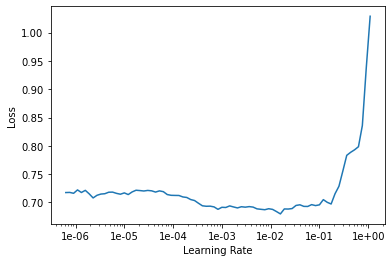

In [73]:
import torch
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy, callback_fns=[OverSamplingCallback])
learn.lr_find()
learn.recorder.plot()

In [67]:
# apply label balancing
labels = learn.data.train_dl.y.items
_, label_counts = np.unique(labels,return_counts=True)
redux = int(np.min(label_counts) * 0.5)
label_counts[0] = label_counts[0] + redux
label_counts[1] = label_counts[1] - redux
weights = torch.DoubleTensor((1/label_counts)[labels])
total_len_oversample = int(learn.data.c*np.max(label_counts))
total_len_oversample

1114

In [68]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.669118,0.714955,0.450000,00:01
1,0.654724,0.764853,0.400000,00:01
2,0.665112,0.738811,0.471429,00:01
3,0.671753,0.786558,0.557143,00:01
4,0.661823,0.829452,0.335714,00:01
5,0.665434,0.772577,0.435714,00:01
6,0.652780,0.715714,0.607143,00:01
7,0.654663,0.745116,0.450000,00:01
8,0.655720,0.736131,0.442857,00:01
9,0.651177,0.694471,0.592857,00:01


In [72]:
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

precision: 0.9509803921568627
sensitifity: 0.10526315789473684


In [78]:
learn.load('best_so_far_2')
interp_best = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
#interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp_best), 1), "%")
#plot_roc_curve(interp)
cm = interp_best.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')
plot_roc_curve(interp_best)
interp_best.plot_confusion_matrix(figsize=(10, 10), dpi=60)

RuntimeError: Error(s) in loading state_dict for TabularModel:
	Unexpected key(s) in state_dict: "embeds.0.weight", "embeds.1.weight", "embeds.2.weight". 
	size mismatch for bn_cont.weight: copying a param with shape torch.Size([161]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for bn_cont.bias: copying a param with shape torch.Size([161]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for bn_cont.running_mean: copying a param with shape torch.Size([161]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for bn_cont.running_var: copying a param with shape torch.Size([161]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for layers.0.weight: copying a param with shape torch.Size([200, 191]) from checkpoint, the shape in current model is torch.Size([200, 1]).

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [ ]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
Image(graph.create_png())

# 5. Generate Heatmaps

In [ ]:
import seaborn as sns

train = pd.read_csv(f'{PATH}/train.csv')
train = train.fillna(0).drop(columns=['label2'])
corr = train.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(25, 25))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.5, square=True)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Choose a subset of features for clustering
dd = train.iloc[:,1:50]

# sns.clustermap(d, linewidths=.5, figsize=(13,13))
m = train.to_numpy()

Z = linkage(m,'ward')

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
pp = sns.clustermap(train.iloc[1:10, 1:50], col_cluster=True, z_score=1)
plt.figure(figsize=(15, 15))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [ ]:
# Choose a subset of features for clustering
dd = train.iloc[:,100:-10]

pp = sns.clustermap(dd.corr(), linewidths=1, figsize=(20,20))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()

In [ ]:
interp_demographic
interp_radiomics
interp_all
interp_best

off = 0.02
lw = 2
indx = 1

plt.figure("roc-curve", figsize=(10,10))

# 1. demo
x, y = roc_curve(interp_demographic.preds[:, indx], interp.y_true)
auc_v = auc(x, y)
plt.plot(x, y, color='red',
             label='Demographic (AUC = %0.2f)' % auc_v)

# 1. radiomic
x, y = roc_curve(interp_radiomics.preds[:, indx], interp.y_true)
auc_v = auc(x, y)
plt.plot(x, y, color='orange',
             label='Radiomic (AUC = %0.2f)' % auc_v)

# 1. all
x, y = roc_curve(interp_all.preds[:, indx], interp.y_true)
auc_v = auc(x, y)
plt.plot(x, y, color='blue',
             label='All (AUC = %0.2f)' % auc_v)

# 1. best
x, y = roc_curve(interp_best.preds[:, indx], interp.y_true)
auc_v = auc(x, y)
plt.plot(x, y, color='purple',
             label='Best (AUC = %0.2f)' % auc_v)

plt.grid(alpha=0.25)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for differentiating benign and malignant tumors')
plt.legend(loc="lower right")